In [158]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
import Time_approximations as Ta
from functools import partial
from scipy.integrate import quad
from singlelocusmodelextended import SingleLocusModelExt as Slme 

def meandiffT(self, fullarr, diffT):
        means0 = []
        means1 = []
        for j in range(len(fullarr)):
            update = np.array([True] * len(fullarr[j]))
            update[diffT[j]] = False
            if update.any(): 
                m0 = np.median(fullarr[j][update])
            else:
                m0 = 0    
            m1 = np.median(fullarr[j][~update])
            means0.append(m0)
            means1.append(m1)
        return means0, means1
    

In [83]:
def τ(w_i, w_j, x, y):
    """j invades i, starting at freq y and reaching freq x
    """
    return np.log((x * (1-y)) / ((1-x) * y)) / np.log(w_j / w_i)

def T(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=0, PLOT_N=False, PLOT_δ=False ):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - 2*((w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - 2*((w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - 2*((w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
    δ=np.array([δ])
    if δ.all() == 0:
        p_anmt_eumt = 1
    else: p_anmt_eumt = 1 - (1 - 2*((w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here...
    

    
    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # 
    τ_euwt_eumt = τ(w_euwt, w_eumt, x=0.95, y=np.maximum(x_0,1/N))
    # start with one or delta*N individuals  # why delta*N and not 2*s*delta*N
    τ_euwt_anwt = τ(w_euwt, w_anwt, x=1-1/N, y=np.maximum(δ, 1/N)) 
    # 
    τ_anwt_anmt = τ(w_anwt, w_anmt, x=1-1/N, y=np.maximum(μ2,1/N))
     # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ(w_anwt, w_eumt, x=0.95, y=np.maximum(δ, 1/N))
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        1/p_min 
        + 1/p_anwt_anmt 
        + 1/p_anmt_eumt 
        + τ_euwt_anwt  
#        + τ_anwt_anmt  # no fix of anmt, don't count
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    
    if PLOT_N:
        plt.plot(N, 1/p_min, label='T_min', color='blue')
        plt.plot(N, 1/p_anwt_anmt, label='T_anwt_anmt', color='orange' )
        plt.plot(N, 1/p_anmt_eumt, label='T_anmt_eumt', color='red' )
        plt.plot(N, τ_euwt_anwt, '--', label='τ_euwt_anwt', color='orange')
        plt.plot(N, τ_anwt_anmt, '--', label='τ_anwt_anmt', color='red')
        plt.plot(N, τ_anmt_eumt, '--', label='τ_anmt_eumt', color='purple')
        plt.legend()
#         plt.yscale('log')
        plt.xscale('log')
        plt.ylim(0, None)
        
    if PLOT_δ:
        plt.plot(δ, 1/p_min, label='T_min', color='blue')
        plt.plot(δ, [1/p_anwt_anmt for d in δ], label='T_anwt_anmt', color='orange' )
        plt.plot(δ, 1/p_anmt_eumt, label='T_anmt_eumt', color='red' )
        plt.plot(δ, τ_euwt_anwt, '--', label='τ_euwt_anwt', color='orange')
        plt.plot(δ, [τ_anwt_anmt for d in δ], '--', label='τ_anwt_anmt', color='red')
        plt.plot(δ, τ_anmt_eumt, '--', label='τ_anmt_eumt', color='purple')
        plt.legend()
#         plt.yscale('log')
        plt.xscale('log')
        plt.ylim(0, None)
    return T

In [3]:
def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0] #  limit=100

def mpintegral(f, N, s, a, b):
    f = partial(f, N, s)    
    return mp.quad(f, [a, b], verbose=False)

def I1(N, s, x):
    if x == 1:
        return 0
    S = 2*N*s
#     return np.expm1(S*x) * (np.exp(-S*x) - np.exp(-S)) / (x * (1-x)) # first term overflow so I rearranged:
    return (np.exp(-S) - np.exp(-S*x) - np.expm1(-S*(1-x))) / (x * (1-x))

def I2(N, s, x):
    if x == 0:
        return 0
    S = 2*N*s
    # use mp instad of np for high precision due to expm1(S*x)
    return -mp.expm1(S*x) * mp.expm1(-S*x) / (x * (1-x)) 

def p_kimura(N, s, x0=None):
    if x0 is None: x0 = 1 / N
    S = 2 * N * s
    numer = np.expm1(-S * x0)
    denom = np.expm1(-S)
    return numer / denom

@np.vectorize
def τ_kimura(N, w_i, w_j, x, y):
    """j invades i, starting at freq y and reaching freq x
    """
    s = (w_j - w_i) / w_i    
    x0, max_x, min_x = y, x, 0
    S = 2 * N * s
    J1 = -1.0 / (s * np.expm1(-S)) * integral(I1, N, s, x0, max_x)
    u = p_kimura(N, s, x0)
    # use mpintegral with mp.quad for high precision due to expm1(S*x) in I2
    J2 = -1.0 / (s * np.expm1(-S)) * mpintegral(I2, N, s, min_x, x0)
#     print(J1, J2, u, 1-u)
    return J1 + ((1 - u) / u) * J2 # eq 17 in Kimura & Ohta, Genetics 1969

In [4]:
def T_kimura(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=0):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - p_kimura(N, (w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - p_kimura(N, (w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
#     p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here but it doesnt seem to matter
    
    δ=np.array([δ])
    if δ.all() == 0:
        p_anmt_eumt = 1
    else: p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N  # N doesnt make sense here...
    

    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # τ_kimura(N, s, x0=None, max_x=1, min_x=0)
    τ_euwt_eumt = τ_kimura(N, w_euwt, w_eumt, x=0.95, y=np.maximum(x_0,1/N))
    # start with one or delta*N individuals
    τ_euwt_anwt = τ_kimura(N, w_euwt, w_anwt, x=1-1/N, y=np.maximum(δ, 1/N)) 
    # no fix of anmt, don't count
    # τ_anwt_anmt = τ_kimura(N, w_anwt, w_anmt, x=1-1/N, y=1/N)
    # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ_kimura(N, w_anwt, w_eumt, x=0.95, y=np.maximum(δ, 1/N))
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        # euwt->anwt
        1/p_min 
        + τ_euwt_anwt 
        # anwt->anmt
        + 1/p_anwt_anmt 
#         + τ_anwt_anmt  # no fix of anmt, don't count
        # anmt->eumt
        + 1/p_anmt_eumt
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    return T

## Population size

In [246]:
Nm58, msim_N_58_manu = np.load('msim_N_58_manu.npy',allow_pickle=True)
Nm58 = Nm58.astype('float64')

dirmut=msim_N_58_manu[1]
msim_N_58_manu=np.array([x for x in msim_N_58_manu[0]])

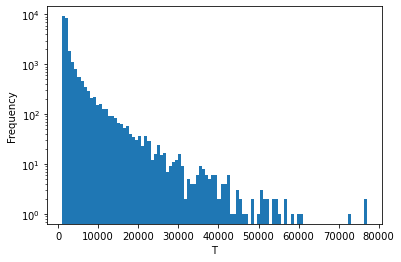

In [247]:
plt.hist((msim_N_58_manu.ravel()), 100);
plt.xlabel('T')
plt.ylabel('Frequency')
#plt.xlim([1e6,5e6])
#plt.xscale('log')
plt.yscale('log');

In [248]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = Nm58, 9.6e-08, 5.4e-4, 1, 1.021, 1.025, 1.028

T__ = T(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=δ)
T_ = T_kimura(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)

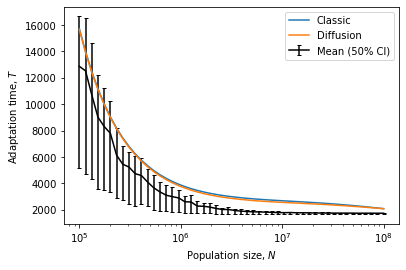

In [249]:
mean = np.mean(msim_N_58_manu, axis=1)
low = np.percentile(msim_N_58_manu, 25, axis=1)
high = np.percentile(msim_N_58_manu, 75, axis=1)
plt.errorbar(N, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(N, T__, label='Classic')
plt.plot(N, T_, label='Diffusion')


plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([1000,12000])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [250]:
Nm58[-21], mean[-21]

(5963623.0, 1839.194)

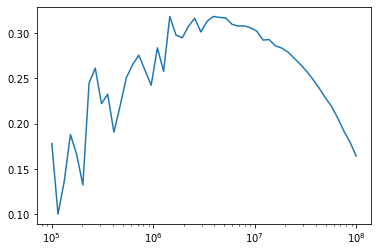

In [84]:
plt.plot(N, (T_-mean)/T_, label='Diffusion')


plt.xscale('log')

In [76]:
nom, noa = meandiffT(_, msim_N_58_manu, dirmut)

C:\Users\aboas\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aboas\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [77]:
T__a = T(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_a = T_kimura(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)
T__m = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_m = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)

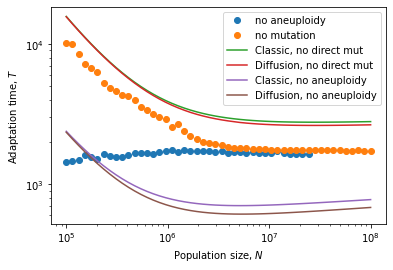

In [161]:
plt.plot(N, noa, 'o', label='no aneuploidy')
plt.plot(N, nom, 'o', label='no mutation')

plt.plot(N, T__a, label='Classic, no direct mut')
plt.plot(N, T_a, label='Diffusion, no direct mut')
plt.plot(N, T__m, label='Classic, no aneuploidy')
plt.plot(N, T_m, label='Diffusion, no aneuploidy')


plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [102]:
Nm58, msim_N_58_manu2 = np.load('msim_N_58_manu2.npy',allow_pickle=True)

In [146]:
dirmut, mix=np.array([x for x in msim_N_58_manu2[1]]).T

<ipython-input-146-2f836f83109f>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dirmut, mix=np.array([x for x in msim_N_58_manu2[1]]).T


In [153]:
np.shape(mix[-15])

(99,)

In [155]:
dirmut[-15]

array([18], dtype=int64)

In [156]:
dirmut

array([array([33, 37, 60, 63, 67, 96], dtype=int64),
       array([ 6,  7, 11, 19, 21, 61, 68, 71], dtype=int64),
       array([ 6, 31, 33, 44, 56, 61, 65, 68], dtype=int64),
       array([16, 17, 21, 33, 35, 45, 55, 59, 78, 93], dtype=int64),
       array([ 1,  4, 46, 59, 66, 81, 86, 91], dtype=int64),
       array([ 0, 10, 14, 17, 28, 41, 59, 67, 94], dtype=int64),
       array([22, 26, 36, 53, 80, 89, 90, 94, 97], dtype=int64),
       array([ 6, 37, 44, 47, 52, 70, 79, 84, 91, 97], dtype=int64),
       array([ 7, 16, 26, 28, 30, 37, 47, 53, 55, 57, 59, 64, 85, 88, 92, 97, 98],
      dtype=int64),
       array([ 3,  7, 17, 24, 27, 30, 33, 36, 41, 43, 63, 65, 73, 76, 79, 83, 91,
       98], dtype=int64),
       array([ 6, 14, 21, 34, 39, 43, 47, 59, 62, 65, 71, 73, 78, 85, 88, 91, 99],
      dtype=int64),
       array([ 0,  4, 13, 15, 16, 24, 34, 35, 44, 45, 52, 53, 61, 68, 74, 78, 90,
       97], dtype=int64),
       array([ 1,  3,  8,  9, 20, 23, 27, 28, 30, 33, 39, 41, 46, 47, 54, 

In [221]:
μm, msim_mu = np.load('msim_mu.npy',allow_pickle=True)
μm = μm.astype('float64')

dirmut=msim_mu[1]
msim_mu=np.array([x for x in msim_mu[0]])

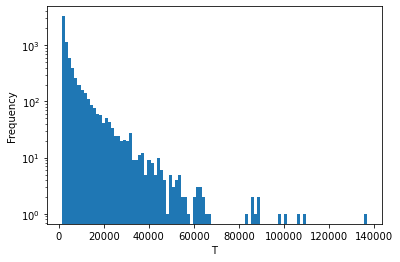

In [222]:
plt.hist((msim_mu.ravel()), 100);
plt.xlabel('T')
plt.ylabel('Frequency')
#plt.xlim([1e6,5e6])
#plt.xscale('log')
plt.yscale('log');

In [223]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, μm, 5.4e-4, 1, 1.021, 1.025, 1.028

T__ = T(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt , x_0=δ)
T_ = T_kimura(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)

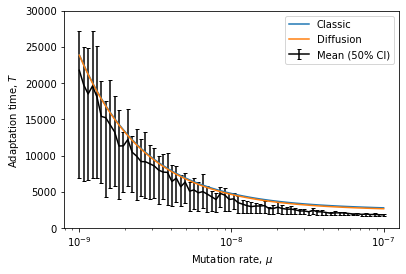

In [227]:
mean = np.mean(msim_mu, axis=1)
low = np.percentile(msim_mu, 25, axis=1)
high = np.percentile(msim_mu, 75, axis=1)
plt.errorbar(μ, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(μ, T__, label='Classic')
plt.plot(μ, T_, label='Diffusion')


plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e7,1e8])
plt.ylim([0,30000])
plt.xlabel("Mutation rate, $μ$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [228]:
μm[-2], mean[-2]

(9.354368899026163e-08, 1829.05)

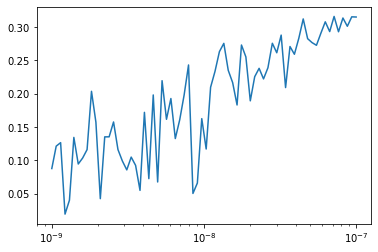

In [175]:
plt.plot(μ, (T_-mean)/T_, label='Diffusion')


plt.xscale('log')

In [229]:
δm, msim_de = np.load('msim_de.npy',allow_pickle=True)
δm = δm.astype('float64')

dirmut=msim_de[1]
msim_de=np.array([x for x in msim_de[0]])

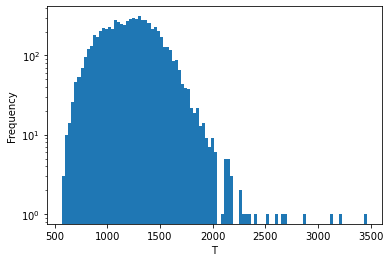

In [230]:
plt.hist((msim_de.ravel()), 100);
plt.xlabel('T')
plt.ylabel('Frequency')
#plt.xlim([1e6,5e6])
#plt.xscale('log')
plt.yscale('log');

In [231]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, 9.6e-8, δm, 1, 1.021, 1.025, 1.028

T__ = T(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt , x_0=δ)
T_ = T_kimura(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt ,x_0=35*μ)

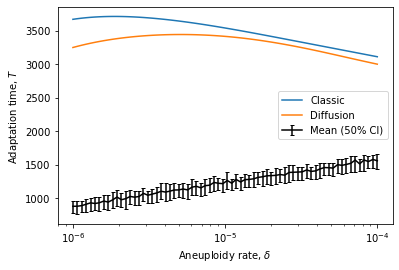

In [232]:
mean = np.mean(msim_de, axis=1)
low = np.percentile(msim_de, 25, axis=1)
high = np.percentile(msim_de, 75, axis=1)
plt.errorbar(δ, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(δ, T__[0], label='Classic')
plt.plot(δ, T_[0], label='Diffusion')


plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([1000,12000])
plt.xlabel("Aneuploidy rate, $δ$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [233]:
δm[-10], mean[-10]

(5.484416576121015e-05, 1499.85)

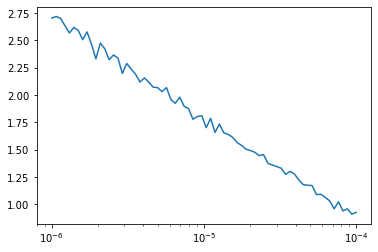

In [197]:
plt.plot(δ, (T_[0]-mean)/mean, label='Diffusion')


plt.xscale('log')